# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.003786,False,-0.449049
1,-1.111213,False,-0.566192
2,0.771729,True,5.487804
3,-1.316513,False,-3.118362
4,-1.661850,False,-3.290917
...,...,...,...
995,-1.646616,False,-2.564661
996,-2.079997,False,-1.348670
997,0.375676,False,0.981494
998,-0.117430,True,6.154845


<AxesSubplot:xlabel='v0'>

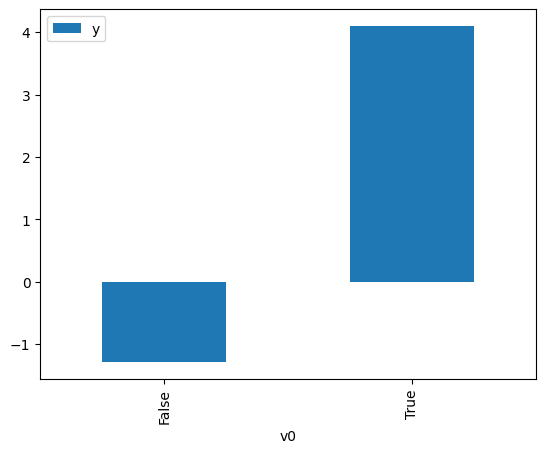

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

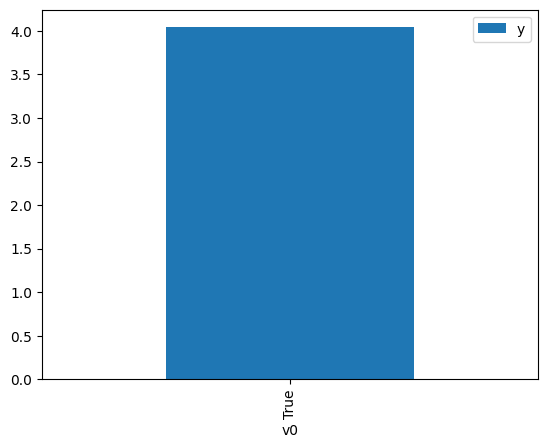

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.430529,False,-1.822646,0.727452,1.374661
1,-0.745473,False,-2.539869,0.849647,1.176960
2,-0.678067,False,-0.337742,0.827968,1.207776
3,0.375676,False,0.981494,0.281224,3.555879
4,-0.394374,False,-1.695263,0.710049,1.408353
...,...,...,...,...,...
995,-0.244153,False,-0.393975,0.631311,1.584006
996,-0.394532,False,0.505836,0.710127,1.408199
997,0.793881,False,1.475256,0.126261,7.920112
998,-1.530155,False,-2.316429,0.973421,1.027305


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.640266,True,4.220012,0.827579,1.208343
1,0.485978,True,6.372760,0.768721,1.300862
2,-0.914870,True,4.126758,0.105714,9.459449
3,-0.914870,True,4.126758,0.105714,9.459449
4,-0.066882,True,4.666756,0.471122,2.122591
...,...,...,...,...,...
995,0.232847,True,3.815552,0.645249,1.549789
996,-1.350949,True,2.311653,0.040160,24.900268
997,-1.536603,True,1.912730,0.026184,38.190694
998,-1.536603,True,1.912730,0.026184,38.190694


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.921
Model:                            OLS   Adj. R-squared (uncentered):              0.921
Method:                 Least Squares   F-statistic:                              5807.
Date:                Mon, 22 Aug 2022   Prob (F-statistic):                        0.00
Time:                        06:37:24   Log-Likelihood:                         -1455.9
No. Observations:                1000   AIC:                                      2916.
Df Residuals:                     998   BIC:                                      2926.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.6941      0.028     59.497      0.000       1.638       1.750
x2             4.8728      0.060     81.838      0.000       4.756       4.990
==============================================================================
Omnibus:                        5.302   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.071   Jarque-Bera (JB):                5.269
Skew:                          -0.154   Prob(JB):                       0.0718
Kurtosis:                       2.823   Cond. No.                         2.12
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""